# Iterative methods

The scripts below compare several different types of gradient-based iterative methods on a smooth 2-D test function of two variables with a single global minimum. The methods compared are:
- Gradient descent
- Nesterov's accelerated method
- BFGS (a Quasi-Newton method)
- Newton's method

The methods are ordered by increasing computational complexity but also increasing speed. So there is a trade-off. Newton's method is extremely fast, but also costly from a memory and storage standpoint. The larger the dimension of the underlying space, the more expensive or difficult it becomes to store and manipulate gradients and Hessians. So when the space is larger, we tend to favor simpler methods such as Gradient descent. The test function we're using is:

$$
f(x,y) = e^{-(x-3)/2} + e^{(x+4y)/10} + e^{(x-4y)/10}
$$

which has a minimum at around $(4.03,0)$.

# Helper functions

In [1]:
# the function we'll be working with
function f(x)
    return exp(-(x[1]-3)/2) + exp((4x[2] + x[1])/10) + exp((-4x[2] + x[1])/10)
end

# the optimal value of x:
xopt = [-(5/6)*(-3 + 2*log(2) - 2*log(5)); 0]
fopt = f(xopt)

# the gradient of the function f(x)
function g(x)
    g1 = -1/2*exp(-(x[1]-3)/2) + 1/10*exp((x[1]-4x[2])/10) + 1/10*exp((x[1]+4x[2])/10)
    g2 = -2/5*exp((x[1]-4x[2])/10) + 2/5*exp((x[1]+4x[2])/10)
    return [g1; g2]
end

# the hessian of the function f(x)
function h(x)
    h11 = 1/4*exp(-(x[1]-3)/2) + 1/100*exp((x[1]-4x[2])/10) + 1/100*exp((x[1]+4x[2])/10)
    h12 = -2/50*exp((x[1]-4x[2])/10) + 2/50*exp((x[1]+4x[2])/10)
    h22 = 4/25*exp((x[1]-4x[2])/10) + 4/25*exp((x[1]+4x[2])/10)
    return [h11 h12; h12 h22]
end
;

# Test a variety of different algorithms

In [2]:
M = 400          # number of iterations we'll do
xstart = [8;-3]   # starting point

# Gradient descent
xg = zeros(2,M)
xg[:,1] = xstart
L = norm(h(xstart))  # heuristic for choosing Lipschitz constant
for k = 1:M-1
    d = -g(xg[:,k])  # descent direction is the negative gradient
    t = 1/L          # constant stepsize (can also do a line search here)
    xg[:,k+1] = xg[:,k] + t*d
end


# Nesterov's accelerated method (variant with constant coefficients)
xh = zeros(2,M)
y = xstart
xh[:,1] = xstart
L = norm(h(xstart))        # heuristic for choosing Lipschitz constant
μ = L/cond(h(xstart))      # heuristic for choosing strong convexity parameter
β = (sqrt(L)-sqrt(μ))/(sqrt(L)+sqrt(μ))   # heuristic for choosing momentum parameter
for k = 1:M-1
    xh[:,k+1] = y - 1/L*g(y)
    y = xh[:,k+1] + β*(xh[:,k+1] - xh[:,k])
end


# BFGS methdod
xb = zeros(2,M)
yb = zeros(2,M)
Bb = eye(2)
xb[:,1] = xstart
gk = g(xb[:,1])
for k = 1:M-1
    gkp = gk
    p = -Bb\gk
    s = p         # can also do a line search here instead
    xb[:,k+1] = xb[:,k] + s
    gk = g(xb[:,k+1])
    y = gk - gkp
    Bb = Bb + (y*y')/dot(y,s) - ((Bb*s)*(Bb*s)')/dot(s,Bb*s)
end


# Newton's method
xn = zeros(2,M)
xn[:,1] = xstart
for k = 1:M-1
    xn[:,k+1] = xn[:,k] - h(xn[:,k])\g(xn[:,k])
end
;

# Plot the contours

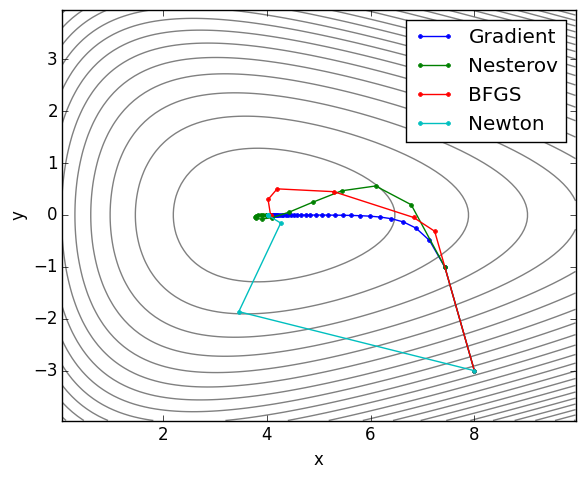

In [4]:
using PyPlot
pygui(false)
figure(figsize=(6,5))


# compute contours of the original function
N = 100
xv = linspace(0,10,N)
yv = linspace(-4,4,N)
fv = zeros(N,N)

for (i,x) in enumerate(xv)
    for (j,y) in enumerate(yv)
        fv[j,i] = f([x;y])
    end
end

contour( fv, origin="lower", extent=(0,10,-4,4), 25, colors="gray" )
plot( xg[1,:], xg[2,:], ".-")
plot( xh[1,:], xh[2,:], ".-")
plot( xb[1,:], xb[2,:], ".-")
plot( xn[1,:], xn[2,:], ".-")
legend(["Gradient", "Nesterov", "BFGS", "Newton"])

axis("image"); xlabel("x"); ylabel("y")
tight_layout();
savefig("ALG_contour.pdf")

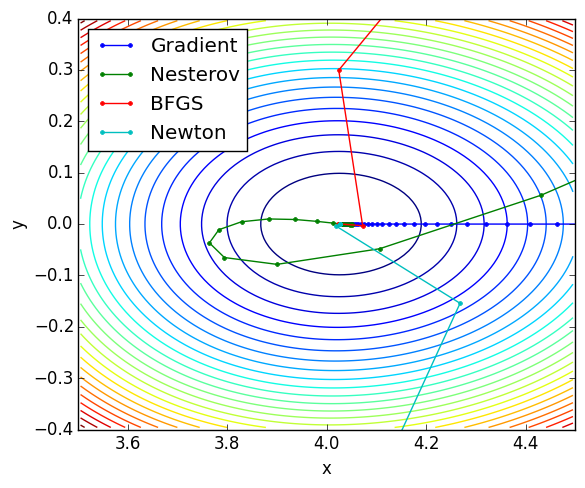

In [5]:
# Again, but more zoomed in this time.

using PyPlot
pygui(false)
figure(figsize=(6,5))


# compute contours of the original function
N = 100
xv = linspace(3.5,4.5,N)
yv = linspace(-.4,.4,N)
fv = zeros(N,N)

for (i,x) in enumerate(xv)
    for (j,y) in enumerate(yv)
        fv[j,i] = f([x;y])
    end
end

contour( fv, origin="lower", extent=(3.5,4.5,-.4,.4), 25 )
plot( xg[1,:], xg[2,:], ".-")
plot( xh[1,:], xh[2,:], ".-")
plot( xb[1,:], xb[2,:], ".-")
plot( xn[1,:], xn[2,:], ".-")
legend(["Gradient", "Nesterov", "BFGS", "Newton"],"best")
axis([3.5,4.5,-.4,.4])
xlabel("x"); ylabel("y")
tight_layout();
savefig("ALG_contour2.pdf")

# Plot convergence rate

In [ ]:
dist_grad = sqrt(sum(( xg - xopt*ones(1,M)).^2,1)');
dist_nest = sqrt(sum(( xh - xopt*ones(1,M)).^2,1)');
dist_bfgs = sqrt(sum(( xb - xopt*ones(1,M)).^2,1)');
dist_newt = sqrt(sum(( xn - xopt*ones(1,M)).^2,1)');

figure(figsize=(10,4))
loglog(1:M, dist_grad)
loglog(1:M, dist_nest)
loglog(1:M, dist_bfgs)
loglog(1:M, dist_newt)
legend(["Gradient", "Nesterov", "BFGS", "Newton"])
axis([1,1e3,1e-14,1e1])
xlabel("number of iterations"); ylabel("distance to optimal point")
tight_layout();
savefig("ALG_convergence.pdf")
;

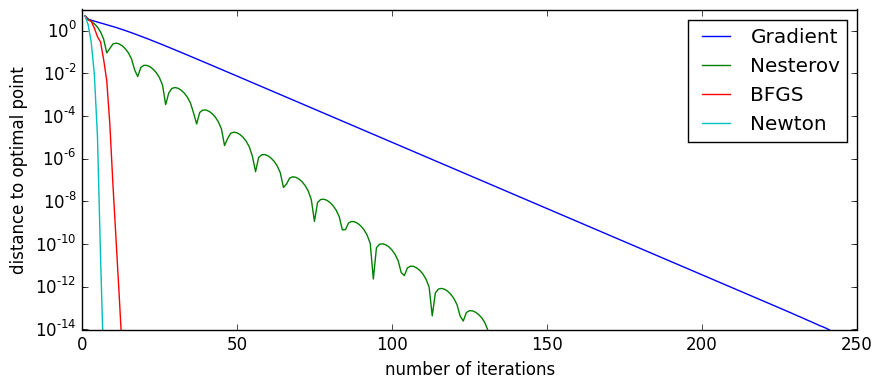

In [18]:
figure(figsize=(10,4))
semilogy(1:M, dist_grad)
semilogy(1:M, dist_nest)
semilogy(1:M, dist_bfgs)
semilogy(1:M, dist_newt)
legend(["Gradient", "Nesterov", "BFGS", "Newton"])
axis([0,250,1e-14,1e1])
xlabel("number of iterations"); ylabel("distance to optimal point")
;